# Прогнозирование температуры плавления стали


___Задача проекта___ 

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

___Описание этапа обработки___

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат.

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов.

___Описание данных___

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

####  План работы

- Подготовка данных: проверка данных на пропуски(избавиться от пропусках в целевом значении температуры), проверка на дубликаты, проверить соответствие типов данных.
- Подготовка признаков. Определить переменные признаки для финальной таблицы, собрать финальную таблицу, разбить данные на обучающую и тестовую выборки.
- Проверка на мультиколлинеарность ДО моделирования
- Подбор моделей для обучения. Подобрать наиболее подходящую регрессионную модель для обучения т.к. в задаче нет уточнения по поводу времени обучения, можно попробовать сложные модели на основе градиентного бустинга
- Анализ важности факторов у модели-победителя
- Оценка модели на тестовой выборке



##  Исследовательны анализ данных


### Загрузка данных и Библиотек

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler 
pd.options.mode.chained_assignment = None
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from scipy import stats as st
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from pyod.models.knn import KNN
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor

import warnings
warnings.filterwarnings('ignore')
from IPython.display import display

In [2]:
data_arc = pd.read_csv('C:/Users/kuzon/Downloads/fin_steel/data_arc.csv')
data_bulk = pd.read_csv('C:/Users/kuzon/Downloads/fin_steel/data_bulk.csv')
data_bulk_time = pd.read_csv('C:/Users/kuzon/Downloads/fin_steel/data_bulk_time.csv')
data_gas = pd.read_csv('C:/Users/kuzon/Downloads/fin_steel/data_gas.csv')
data_temp = pd.read_csv('C:/Users/kuzon/Downloads/fin_steel/data_temp.csv')
data_wire = pd.read_csv('C:/Users/kuzon/Downloads/fin_steel/data_wire.csv')
data_wire_time = pd.read_csv('C:/Users/kuzon/Downloads/fin_steel/data_wire_time.csv')

In [3]:
def info(data, column): # функция на просмотр общей информации по таблице
    display(data)
    print('=====================================================')
    display(data.info())
    print('=====================================================')
    display(data.describe())
    print('=====================================================')
    print('Количество уникальных значений ',len(data[column].unique()))

In [4]:
def find_mustache(data, column):  #функция для поиска усов
    describe = data[column].describe()
    box = describe[6] - describe[4]
    low_mustache = describe[4] - 1.5 * box
    up_mustache = describe[6] + 1.5 * box
    if low_mustache < describe[3]: 
        low_mustache = describe[3]
    if up_mustache > describe[7]:
        up_mustache = describe[7]
    return [low_mustache, up_mustache]

### Данные об электродах


In [5]:
info(data_arc,'key')

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


Количество уникальных значений  3214


Усы  [0.0300019383, 1.5496385341499996]


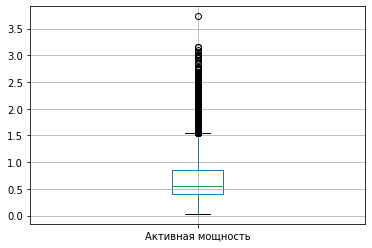

In [6]:
data_arc.boxplot('Активная мощность')
print('Усы ', find_mustache(data_arc, 'Активная мощность'))


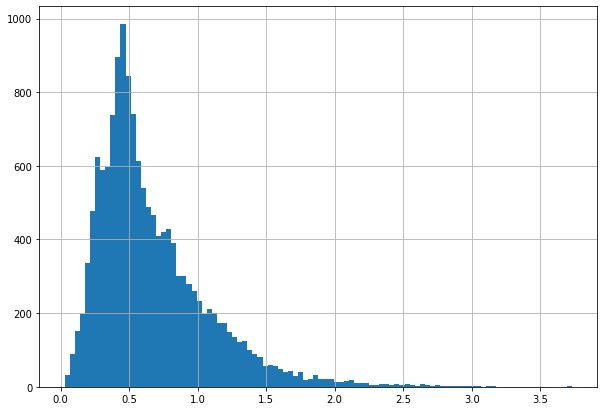

In [7]:
data_arc['Активная мощность'].hist(bins=100, figsize=(10,7))

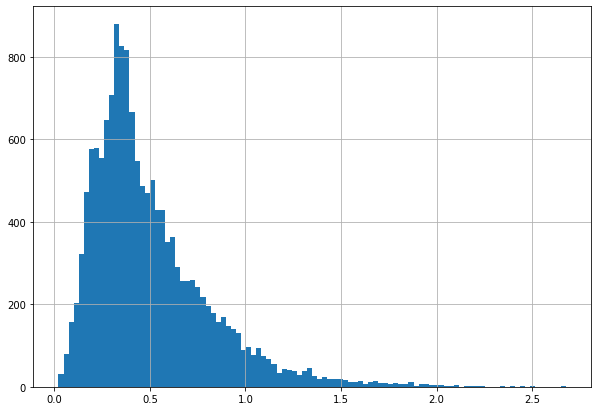

In [8]:
data_arc[data_arc['Реактивная мощность'] > -700]['Реактивная мощность'].hist(bins=100, figsize=(10,7))

In [9]:
data_arc = data_arc[data_arc['Реактивная мощность'] > -700].reset_index(drop=1)

data_arc['Полная мощность'] = ((data_arc['Активная мощность']**2) + (data_arc['Реактивная мощность']**2))**0.5


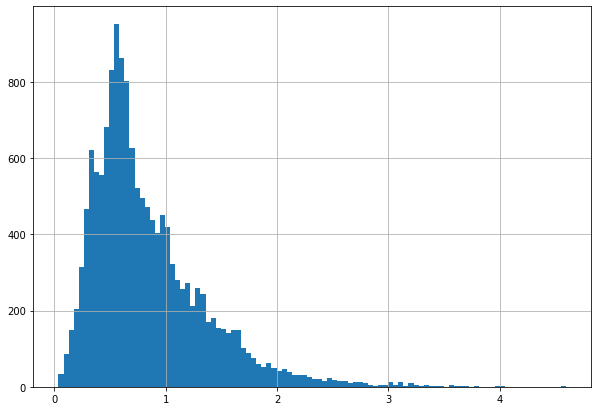

In [10]:
data_arc['Полная мощность'].hist(bins=100, figsize=(10,7))

In [11]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'], format='%Y-%m-%dT%H:%M:%S')
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'], format='%Y-%m-%dT%H:%M:%S')

In [12]:
delta = data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']
delta.describe()#посмотрим на наличие аномалий по времени нагрева 

count                     14875
mean     0 days 00:02:51.675159
std      0 days 00:01:38.188758
min             0 days 00:00:11
25%             0 days 00:01:47
50%             0 days 00:02:27
75%             0 days 00:03:34
max             0 days 00:15:07
dtype: object

,Полная мощность
key,
1,5.826395
2,3.649216
3,2.989534
4,3.814962
5,4.035758
...,...
3237,4.844982
3238,2.696542
3239,5.611883


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F5A8994488>]],
      dtype=object)

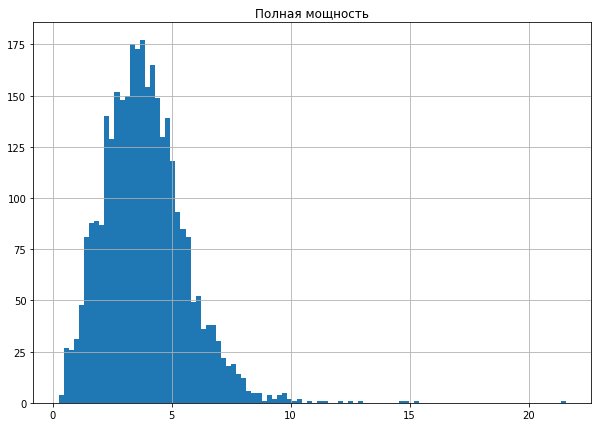

In [13]:
data_arc_sum = data_arc.pivot_table(values = ['Полная мощность'],
                                    index='key',
                                    aggfunc={'Полная мощность': np.sum})
display(data_arc_sum)
data_arc_sum.hist(bins=100, figsize=(10,7))

Усы  [0.25763716041267226, 8.134262426137106]


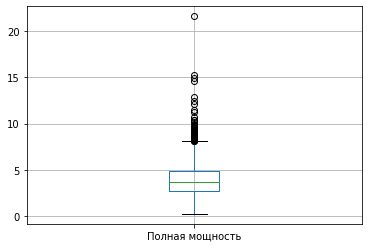

In [14]:
data_arc_sum.boxplot('Полная мощность')
print('Усы ', find_mustache(data_arc_sum, 'Полная мощность'))


#### Выводы по разделу:
- В данных отсутствуют пропуски
- В данных 3214 партий, стоит обратить внимание на то что максимальное значение в партии это 3241, это говорит что некоторые партии отсутствуют
- В Реактивной мощности явная аномалия это мощность -715
- Создали столбец с полной мощностью 
- Данные по мощностям(исключая аномалию) находятся в нормальном распределением со смещением влево
- Время нагрева дуги по итерациям находится в норме(отсутствуют отрицательные и слишком высокие значение), немного смущает время нагрева в 15 минут, но в технологии производства электростали пишут, что время может быть и выше
- Создали таблицу data_arc_sum, для дальнейшего агрегирования, в которой сгрупировали данные по key и суммировали полную мощность, в пердположении чем больше затраченно энергии, тем больше будет температура

### Данные о подаче сыпучих материалов

In [15]:
info(data_bulk, 'key')

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Количество уникальных значений  3129


In [16]:
data_bulk = data_bulk.fillna(0).set_index('key')

In [17]:
data_bulk['Bulk_count_of_add'] = 15 - (data_bulk.loc[:, :"Bulk 15"].eq(0).sum(axis=1))  

In [18]:
data_bulk

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Bulk_count_of_add
key,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,4
2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,4
3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,4
4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,4
5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3237,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0,4
3238,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0,4
3239,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0,4


In [19]:
info(data_bulk_time, 'key')

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,2019-08-31 22:51:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 22:46:52,NaN,2019-08-31 22:46:52,2019-08-31 22:46:52
3125,3238,NaN,NaN,2019-08-31 23:39:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 23:33:09,NaN,2019-08-31 23:33:09,2019-08-31 23:33:09
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:51:58,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:39:41,NaN,2019-09-01 01:33:25,2019-09-01 01:33:25
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-01 03:12:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 02:41:27,2019-09-01 02:41:27


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null object
Bulk 2     22 non-null object
Bulk 3     1298 non-null object
Bulk 4     1014 non-null object
Bulk 5     77 non-null object
Bulk 6     576 non-null object
Bulk 7     25 non-null object
Bulk 8     1 non-null object
Bulk 9     19 non-null object
Bulk 10    176 non-null object
Bulk 11    177 non-null object
Bulk 12    2450 non-null object
Bulk 13    18 non-null object
Bulk 14    2806 non-null object
Bulk 15    2248 non-null object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


Количество уникальных значений  3129


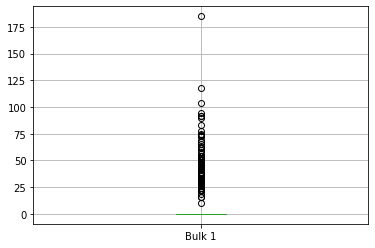

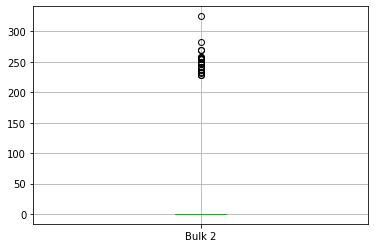

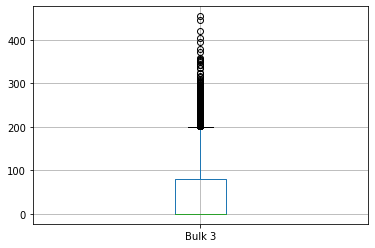

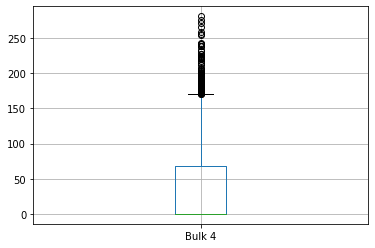

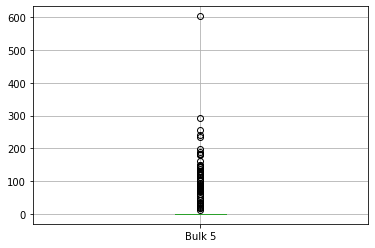

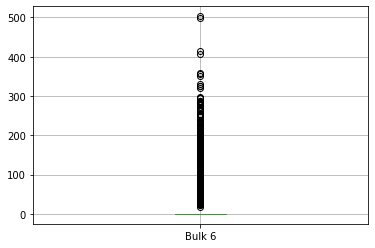

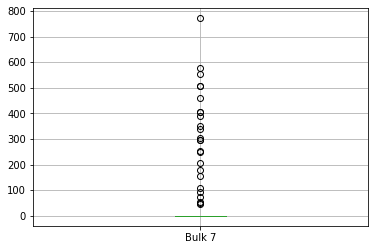

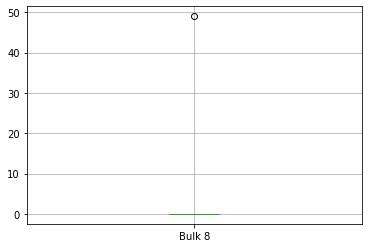

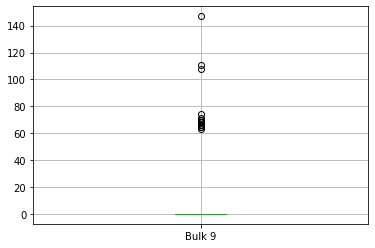

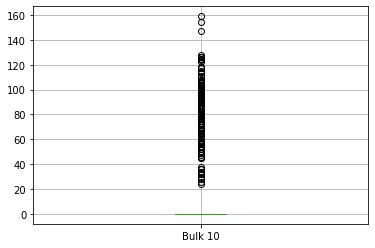

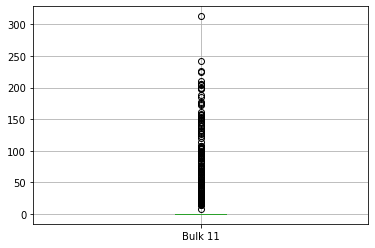

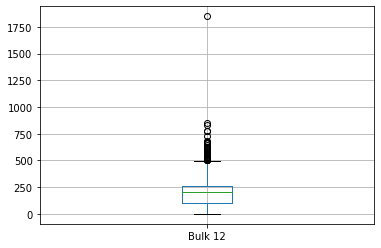

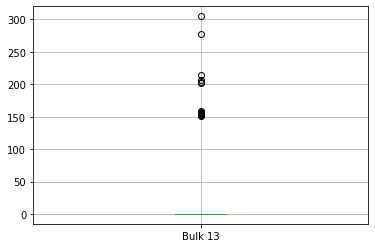

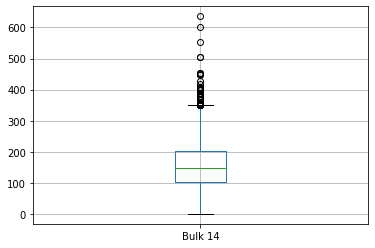

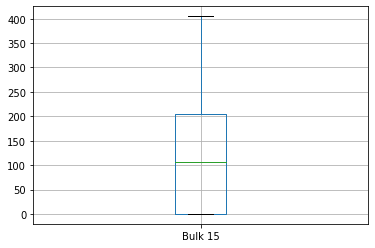

In [20]:
columns_bulk = ['Bulk 1','Bulk 2','Bulk 3','Bulk 4','Bulk 5','Bulk 6','Bulk 7','Bulk 8','Bulk 9','Bulk 10','Bulk 11','Bulk 12','Bulk 13','Bulk 14','Bulk 15']
for column in columns_bulk:
    data_bulk.boxplot(column)
    plt.show()
    

In [21]:
for column in columns_bulk:
    data_bulk_time[column] = pd.to_datetime(data_bulk_time[column], format='%Y-%m-%dT%H:%M:%S')
    

In [22]:
for column in columns_bulk:
    print(len(data_bulk_time[column].value_counts()))

252
22
1298
1014
77
576
25
1
19
176
177
2450
18
2806
2248


In [23]:
data_bulk

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Bulk_count_of_add
key,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,4
2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,4
3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,4
4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,4
5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3237,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0,4
3238,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0,4
3239,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0,4


In [24]:
data_bulk['Bulk_all_volume'] = data_bulk.loc[:, :"Bulk 15"].sum(axis=1)

####  Выводы по разделу:
- В двух таблицах содержится 3129 уникальных партий, таблицы соответствую друг другу
- В таблицах много пропусков, связанно с тем, что в партию добавляют не все присыпки, а доводят до нужного состава 
- В таблице про время подачи присыпок поменяли тип данных на datatime
- В таблице про объем присыпок есть значения, возможные кондидаты на выброс
- В таблице data_bulk пропуски заменили на 0(не добавленный объем равен 0), и добавили столбец с количеством добавления(преполагается, что количество раз введения материала влияет на температуру сплава)


### Данные о продувке сплава газом

In [25]:
info(data_gas,'key')

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Газ 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Количество уникальных значений  3239


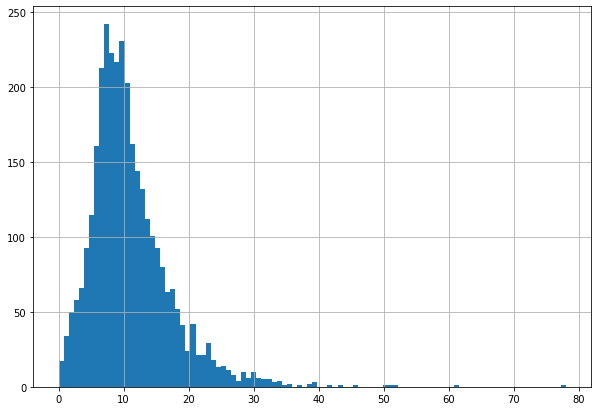

In [26]:
data_gas['Газ 1'].hist(bins=100, figsize=(10,7))

Усы  [0.0083985291, 23.860155585675002]


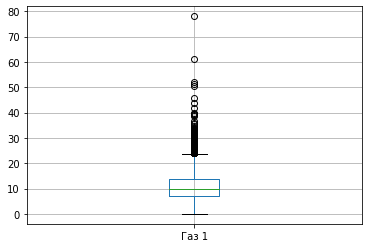

In [27]:
data_gas.boxplot('Газ 1')
print('Усы ', find_mustache(data_gas, 'Газ 1'))

In [28]:
data_gas = data_gas.set_index('key')

#### Выводы по разделу 
- Уникальных партий 3239
- Отсутствуют пропуски
- Распределение нормальное
- Есть очень большие значение  за 60, возможные выбросы

### Результаты измерения температуры

In [29]:
info(data_temp, 'key')

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null object
Температура     13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


Количество уникальных значений  3216


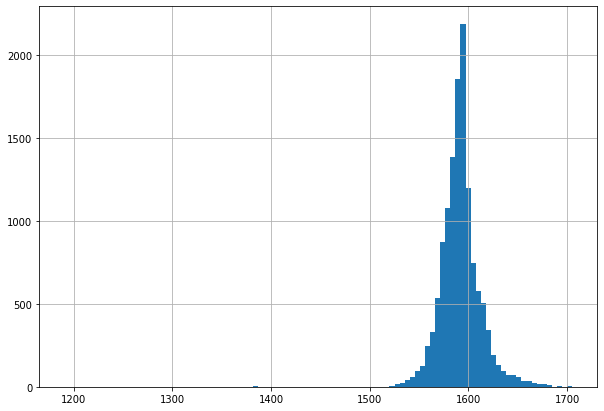

In [30]:
data_temp['Температура'].hist(bins=100, figsize=(10,7))

Усы  [1551.0, 1631.0]


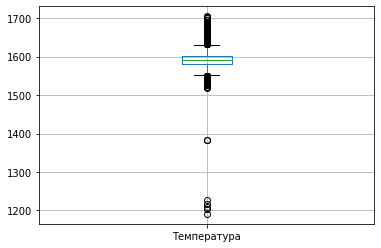

In [31]:
data_temp.boxplot('Температура')
print('Усы ', find_mustache(data_temp, 'Температура'))

In [32]:
data_temp = data_temp.dropna().reset_index(drop=1)

In [33]:
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'], format='%Y-%m-%dT%H:%M:%S')

In [34]:
data_temp['key'].value_counts()

44      16
46      16
1214    16
1513    16
2108    15
        ..
2795     1
2787     1
2779     1
2771     1
2867     1
Name: key, Length: 3216, dtype: int64

In [35]:
good_keys = []
for key in list(data_temp['key'].unique()):
        if ((data_temp[data_temp['key'] == key]['Время замера'].max() >= 
            data_arc[data_arc['key'] == key]['Конец нагрева дугой'].max())) and  (data_temp[data_temp['key'] == key]['Температура'].min()!= (data_temp[data_temp['key'] == key]['Температура'].max())):
            good_keys.append(key)
print(good_keys, len(good_keys))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 44, 45, 46, 47, 48, 49, 50, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 66, 67, 68, 70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 178, 181, 183, 184, 186, 187, 188, 189, 190, 191, 192, 193, 194, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 214, 215, 217, 218, 219, 221, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 24

In [36]:
data_temp = data_temp.query('key  in @good_keys').reset_index(drop=1)
data_temp['key'].value_counts() 

1214    16
1513    16
46      16
44      16
2108    15
        ..
958      2
1801     2
5        2
2194     2
579      2
Name: key, Length: 2341, dtype: int64

In [37]:
data_temp.describe()

,key,Температура
count,11673.000000,11673.000000
mean,1238.683800,1592.072218
std,728.161811,20.775725
min,1.000000,1191.000000
25%,613.000000,1581.000000
50%,1241.000000,1591.000000
75%,1875.000000,1601.000000
max,2499.000000,1705.000000


#### Выводы по разделу
- Данные по температуре распределенны нормально, смущают температуры ниже 1500 градусов
- В данных по температуре присутствуют пропуски, есть данные в которых производился только один замер температуры
- Т.к температура это наш ключевой признак, от некачественных данных(нет замеров после конца нагрева дугой) и пропусков избавились

###  Данные о проволочных материалах

In [38]:
info(data_wire, 'key')

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060484,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Количество уникальных значений  3081


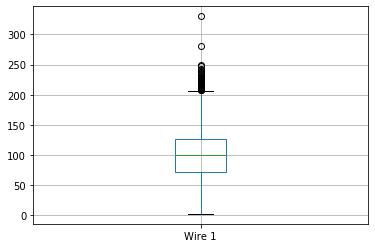

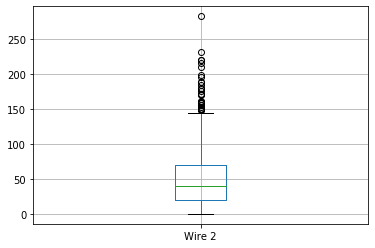

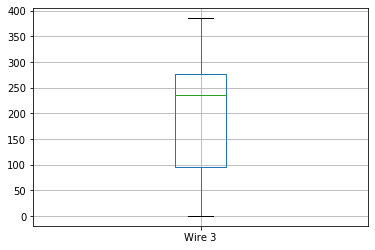

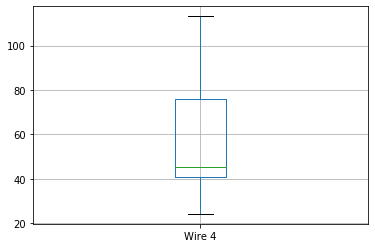

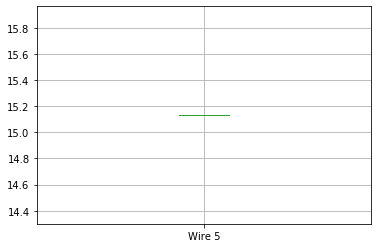

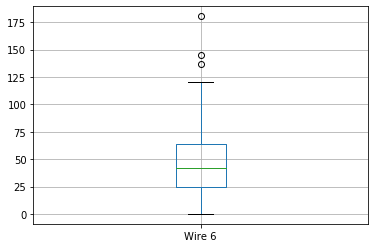

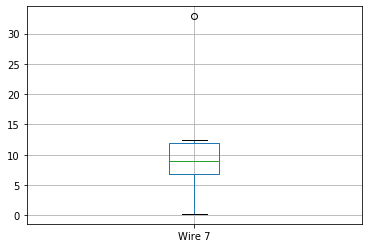

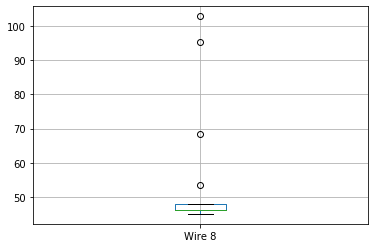

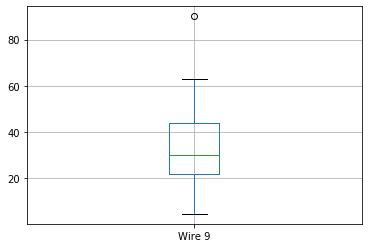

In [39]:
columns_wire = ['Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9']
for column in columns_wire:
    data_wire.boxplot(column)
    plt.show()

In [40]:
info(data_wire_time, 'key')

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-08-31 22:50:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-08-31 23:38:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-01 01:50:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-01 03:12:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null object
Wire 2    1079 non-null object
Wire 3    63 non-null object
Wire 4    14 non-null object
Wire 5    1 non-null object
Wire 6    73 non-null object
Wire 7    11 non-null object
Wire 8    19 non-null object
Wire 9    29 non-null object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


Количество уникальных значений  3081


In [41]:
for column in columns_wire:
    data_wire_time[column] = pd.to_datetime(data_wire_time[column], format='%Y-%m-%dT%H:%M:%S')

In [42]:
for column in columns_wire:
    print(len(data_wire_time[column].value_counts()))

3055
1079
63
14
1
73
11
19
29


In [43]:
data_wire = data_wire.fillna(0).set_index('key')

In [44]:
data_wire['Wire_count_of_add'] = 9 - (data_wire.loc[:, :"Wire 9"].eq(0).sum(axis=1)) 

In [45]:
data_wire

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Wire_count_of_add
key,,,,,,,,,,
1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...
3237,38.088959,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3238,56.128799,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3239,143.357761,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [46]:
data_wire['Wire_all_volume'] = data_wire.loc[:, :"Wire 9"].sum(axis=1)

#### Выводы по разделу
- В данных 3081 партия, таблицы соответствуют друг другу
- В Данных много пропусков, связано с тем, что не все матереалы добавляют в сплав
- В данных про время  поменяли формат на  datatime
- В таблицу data_wire добавили столбец с количеством раз добавления материалов6 и пропуски заменили на 0, аналогично данным о присыпках

### Вывод по главе

- Пропуски значений в столбцах. Возможно это ошибка датчика, который не передал информацию или отсутствие действия/замера на этой стадии.  
- В таблицах data_bulk и data_wire указаны 15 и 9 столбцов о различных материалах. Это значит, что в каждую партию может идти определенный набор из них и только единицам требуется использование всех возможных материалов.
- В таблицах разное количество уникальных номеров партии key. Это может означать, что данные по партии могут быть утеряны или над ней не выполнялся технологический этап.
- Перевели все время в формат datetime.
- Таблицы data_arc и data_temp обладают записями с одинаковыми значениями key в разное время применения технологической операции. Количество записей у одной партии для каждой таблицы может различаться.
- Выявили значения  key  в таблице data_temp, которые в дальнейшем можно использовать в агрегировании данных
- Избавились от пропусков в data_temp(ключевой признак)
- Избавились от  аномального значения реактивной мощности в таблице data_arc.

## Агрегирование данных

In [47]:
data_temp.columns = ['key', 'time','temp']

In [48]:
data_temp_2time = data_temp.pivot_table(values = 'time',
                                        index = 'key',
                                        aggfunc = {'time': [np.min, np.max]})
 #данные по партиям начало замера температуры и конец

In [49]:
start_time_list = list(data_temp_2time['amin'])
end_time_list = list(data_temp_2time['amax'])
data_temp_start_temp = data_temp.query('time in @start_time_list ')
data_temp_start_temp = data_temp_start_temp.set_index('key')
data_temp_end_temp = data_temp.query('time in @end_time_list ')
data_temp_end_temp = data_temp_end_temp.set_index('key')
data_temp_final = data_temp_start_temp.copy()
data_temp_final.columns = ['time','start_temp']
data_temp_final['end_temp'] = data_temp_end_temp['temp']
data_temp_final = data_temp_final.drop('time', axis=1)
data_temp_final.head()

,start_temp,end_temp
key,,
1,1571.0,1613.0
2,1581.0,1602.0
3,1596.0,1599.0
4,1601.0,1625.0
5,1576.0,1602.0


Создали таблицу замеров температуры в начале и конце

#### Создание общей таблицы

In [50]:
data_final = data_temp_final.merge(data_arc_sum, left_index = True , right_index = True, how='outer')

In [51]:
data_final =  data_final.merge(data_bulk, left_index = True , right_index = True, how='outer')

In [52]:
data_final = data_final.merge(data_gas, left_index = True , right_index = True, how='outer')

In [53]:
data_final = data_final.merge(data_wire, left_index = True , right_index = True, how='outer')

In [54]:
data_final = data_final.dropna()
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2207 entries, 1 to 2499
Data columns (total 32 columns):
start_temp           2207 non-null float64
end_temp             2207 non-null float64
Полная мощность      2207 non-null float64
Bulk 1               2207 non-null float64
Bulk 2               2207 non-null float64
Bulk 3               2207 non-null float64
Bulk 4               2207 non-null float64
Bulk 5               2207 non-null float64
Bulk 6               2207 non-null float64
Bulk 7               2207 non-null float64
Bulk 8               2207 non-null float64
Bulk 9               2207 non-null float64
Bulk 10              2207 non-null float64
Bulk 11              2207 non-null float64
Bulk 12              2207 non-null float64
Bulk 13              2207 non-null float64
Bulk 14              2207 non-null float64
Bulk 15              2207 non-null float64
Bulk_count_of_add    2207 non-null float64
Bulk_all_volume      2207 non-null float64
Газ 1                2207 non-nul

In [55]:
data_final_1 = data_final.drop(columns = columns_bulk)
data_final_1 = data_final_1.drop(columns = columns_wire)

In [56]:
columns_drop = ['Bulk_all_volume','Wire_all_volume']
data_final_2 = data_final.drop(columns = columns_drop)
data_final_2

,start_temp,end_temp,Полная мощность,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Wire_count_of_add
key,,,,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,5.826395,0.0,0.0,0.0,43.0,0.0,0.0,0.0,...,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1581.0,1602.0,3.649216,0.0,0.0,0.0,73.0,0.0,0.0,0.0,...,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1596.0,1599.0,2.989534,0.0,0.0,0.0,34.0,0.0,0.0,0.0,...,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1601.0,1625.0,3.814962,0.0,0.0,0.0,81.0,0.0,0.0,0.0,...,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,1576.0,1602.0,4.035758,0.0,0.0,0.0,78.0,0.0,0.0,0.0,...,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1570.0,1591.0,3.986869,0.0,0.0,21.0,0.0,0.0,0.0,0.0,...,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2496,1554.0,1591.0,5.057033,0.0,0.0,0.0,63.0,0.0,0.0,0.0,...,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2497,1571.0,1589.0,2.885017,0.0,0.0,0.0,85.0,0.0,0.0,0.0,...,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


В моделировании будем использовать два набора данных в df_1  будут данные с общим объемом присыпок и проволки, и количества добавления в df_2  будут данные по каждой присыпке и проволке отдельно

#### Проверка на мультиколлинеарность

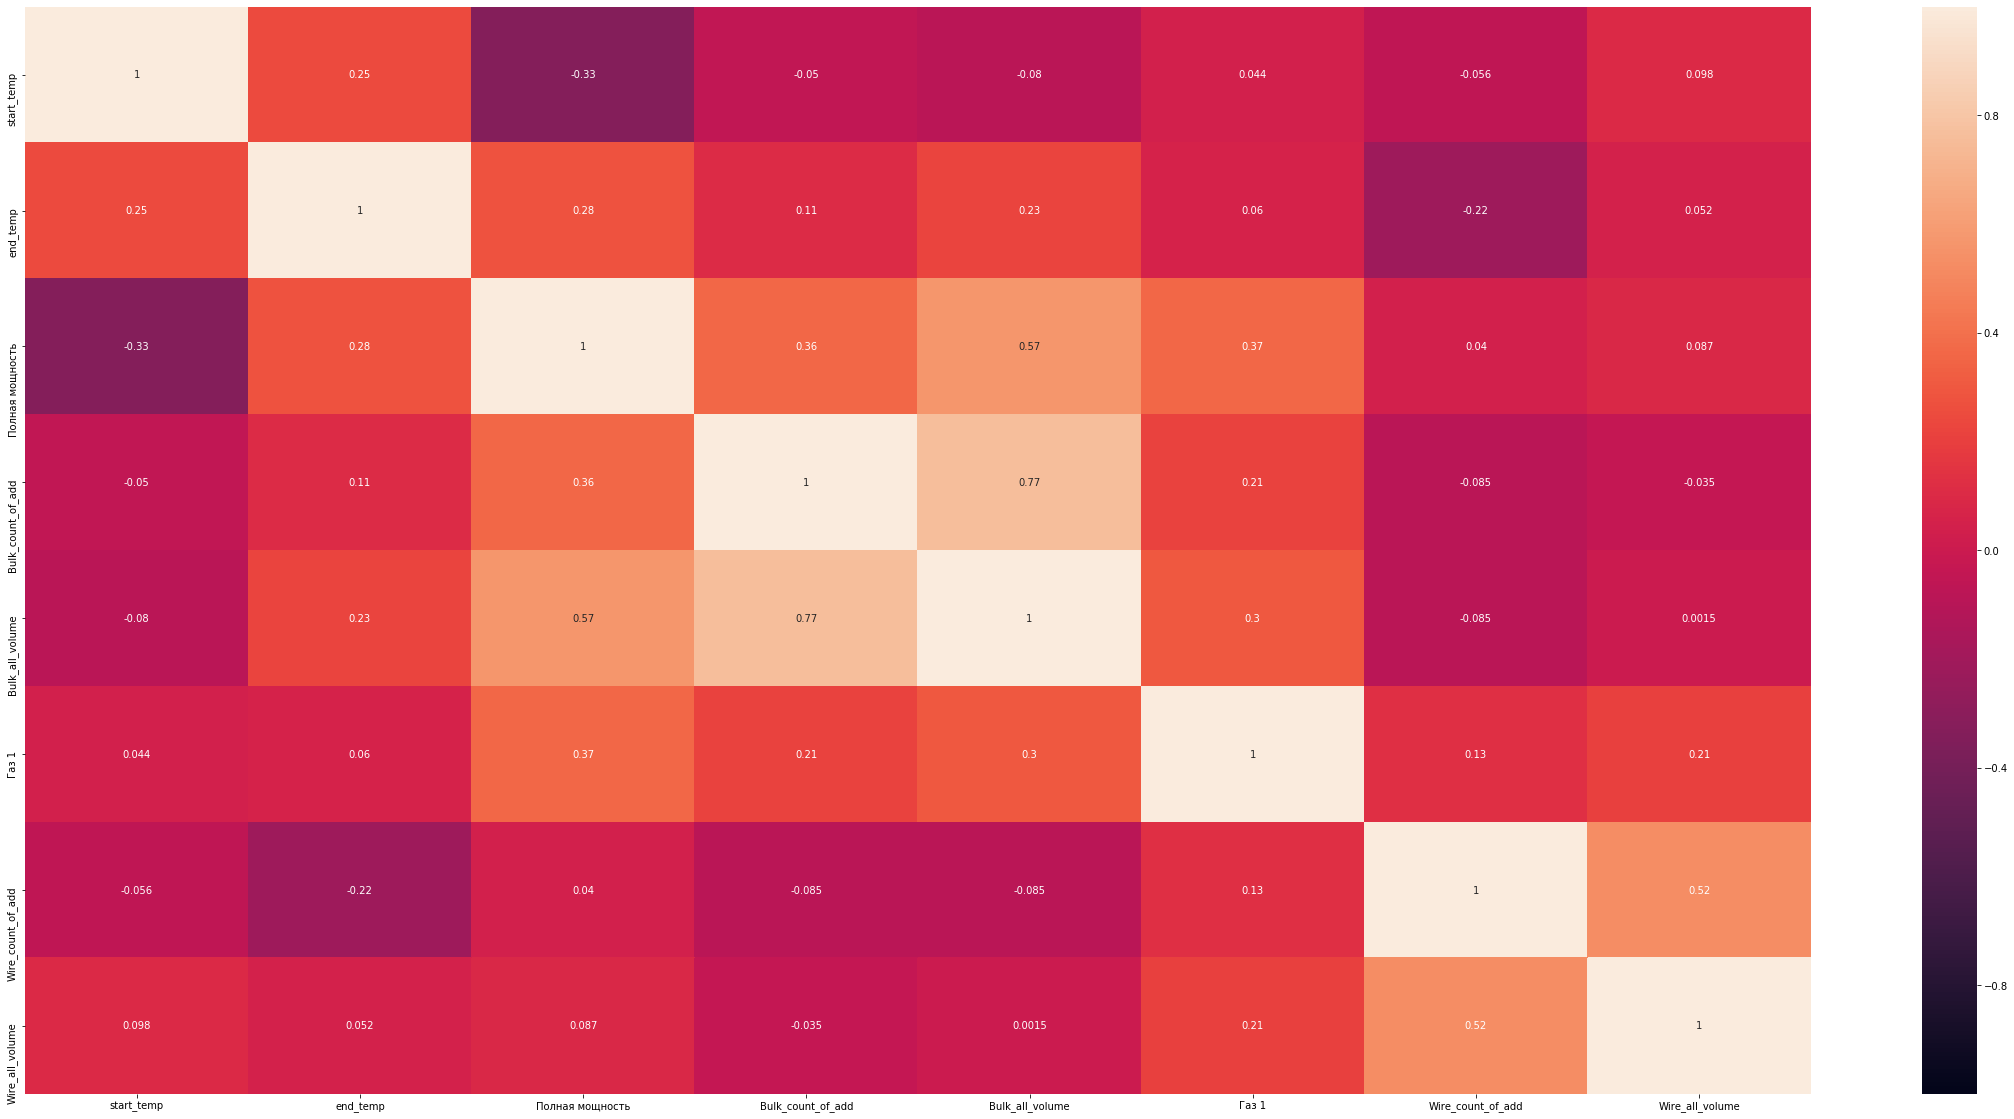

In [57]:
plt.figure(figsize=(40, 20))
sns.heatmap(data_final_1.corr(), vmin=-1, vmax=1, annot=True) 


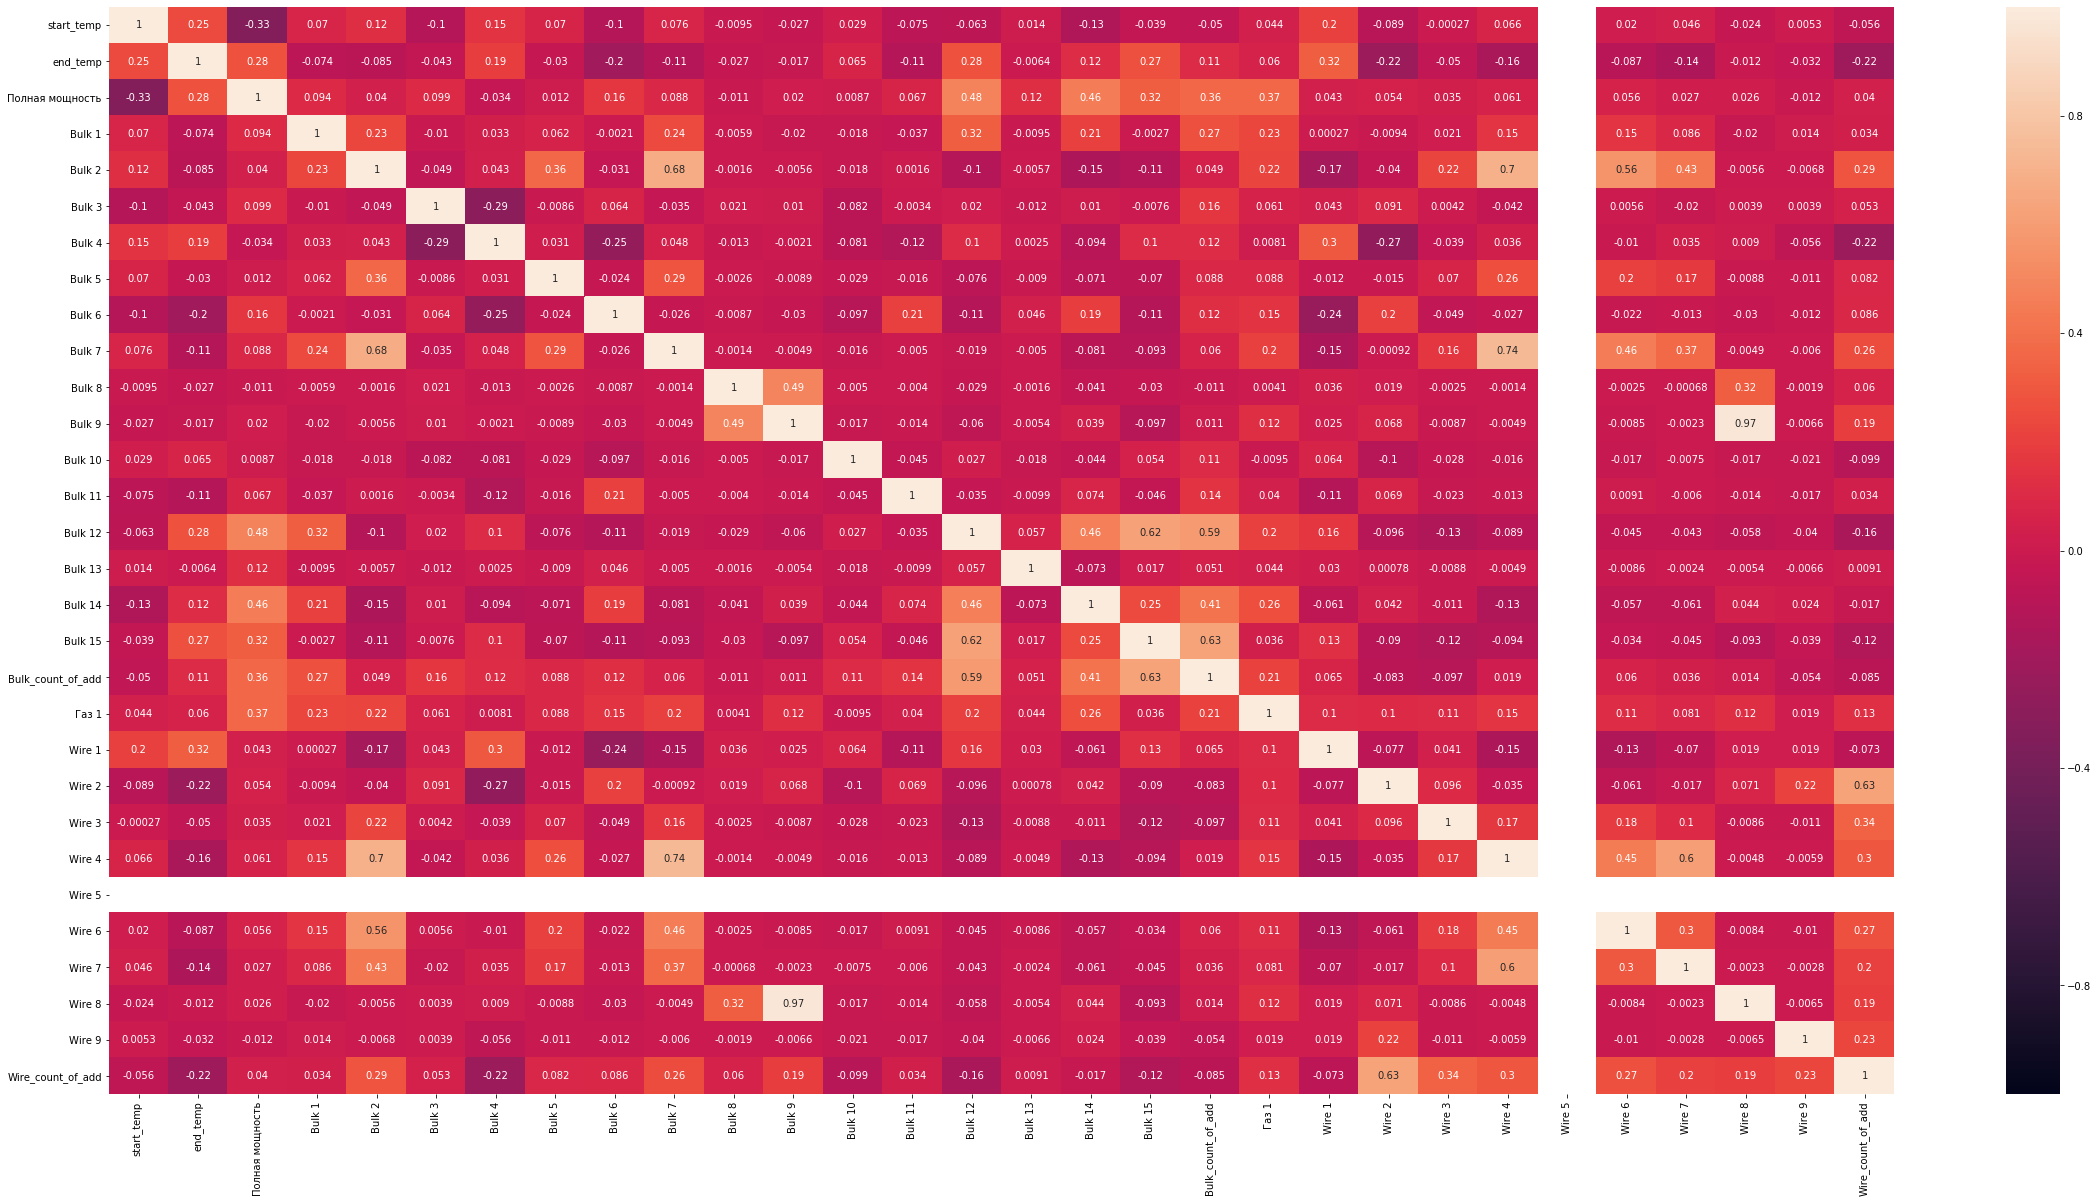

In [58]:
plt.figure(figsize=(40, 20))
sns.heatmap(data_final_2.corr(), vmin=-1, vmax=1, annot=True) 


Видно, что большая корреляция между Bulk 9 и Wire 8, Wire 5 удалим из-за отсутствия данных, также   Bulk 12, Bulk 2, Wire 4, можно удалить за частую высокую  корелляцию по другим признакам

In [59]:
data_final_2 = data_final_2.drop(columns = ['Wire 5', 'Bulk 9', 'Bulk 12', 'Bulk 2', 'Wire 4'])

#### Удаление выбросов

In [60]:
def find_anomaly(data):
    model = KNN()
    model.fit(data)
    data['is_outlier'] =  model.predict(data) == 1
    outliers_knn = data['is_outlier'].sum()

    outlier_indexes = list(data[data['is_outlier'] == 1].index)

    data_steel = data.drop(outlier_indexes)
    return data_steel

In [61]:
df_1 = find_anomaly(data_final_1).drop('is_outlier',axis=1)

In [62]:
df_2 = find_anomaly(data_final_2).drop('is_outlier',axis=1)

In [63]:
df_1 = df_1.rename(columns={'Полная мощность': 'Full power',
                        'Газ 1': 'Gas'})

In [64]:
df_2 = df_2.rename(columns={'Полная мощность': 'Full power',
                        'Газ 1': 'Gas'})

#### Разделение на выборки

In [65]:
train_1, test_1 = train_test_split(df_1, test_size = 0.25, random_state = 12345)

In [66]:
train_2, test_2 = train_test_split(df_2, test_size = 0.25, random_state = 12345)

#### Маштабирование данных

In [67]:
scaler = MinMaxScaler()
numeric_1 = df_1.columns.tolist()
numeric_1 = [i for i in numeric_1 if i not in ('end_temp')]
scaler.fit(train_1[numeric_1])

train_1[numeric_1] = scaler.transform(train_1[numeric_1])
test_1[numeric_1] = scaler.transform(test_1[numeric_1])

In [68]:
numeric_2 = df_2.columns.tolist()
numeric_2 = [i for i in numeric_2 if i not in ('end_temp')]
scaler.fit(train_2[numeric_2])

train_2[numeric_2] = scaler.transform(train_2[numeric_2])
test_2[numeric_2] = scaler.transform(test_2[numeric_2])

In [69]:
feature_train_1 = train_1.drop(['end_temp'], axis = 1)
target_train_1 = train_1['end_temp']

feature_test_1 = test_1.drop(['end_temp'], axis = 1)
target_test_1 = test_1['end_temp']

In [70]:
feature_train_2 = train_2.drop(['end_temp'], axis = 1)
target_train_2 = train_2['end_temp']

feature_test_2 = test_2.drop(['end_temp'], axis = 1)
target_test_2 = test_2['end_temp']

## Моделирование

### LinearRegression

In [71]:
%%time
param_lr_grid = {'fit_intercept':[True, False], 
                 'normalize':[True, False]}

grid_lr = GridSearchCV(LinearRegression(), 
                       param_lr_grid, 
                       cv=5,
                       scoring='neg_mean_absolute_error')

grid_lr.fit(feature_train_1, target_train_1)
params_lr = grid_lr.best_params_
lr = LinearRegression(**params_lr)
lr.fit(feature_train_1, target_train_1)
pred_test = lr.predict(feature_test_1)
print(params_lr)
print("MAE on test: ", mean_absolute_error(target_test_1, pred_test))

{'fit_intercept': True, 'normalize': True}
MAE on test:  6.122463809031874
Wall time: 38.9 ms


In [72]:
%%time
param_lr_grid = {'fit_intercept':[True, False], 
                 'normalize':[True, False]}

grid_lr = GridSearchCV(LinearRegression(), 
                       param_lr_grid, 
                       cv=5,
                       scoring='neg_mean_absolute_error')

grid_lr.fit(feature_train_2, target_train_2)
params_lr = grid_lr.best_params_
lr = LinearRegression(**params_lr)
lr.fit(feature_train_2, target_train_2)
pred_test = lr.predict(feature_test_2)
print(params_lr)
print("MAE on test: ", mean_absolute_error(target_test_2, pred_test))

{'fit_intercept': True, 'normalize': False}
MAE on test:  5.849287695914256
Wall time: 59.9 ms


### RandomForestRegressor

In [73]:
%%time
param_rf_grid = {'n_estimators': [100, 300, 500], 
                 'max_depth': [2, 4, 6], 
                 'min_samples_split': [2, 5, 8], 
                 'max_features': ['auto', 'sqrt', 'log2', None]
                }

grid_rf = GridSearchCV(RandomForestRegressor(random_state=12345), 
                       param_rf_grid, 
                       cv=5,
                       scoring='neg_mean_absolute_error')
grid_rf.fit(feature_train_1, target_train_1)
params_rf = grid_rf.best_params_
rf = RandomForestRegressor(**params_rf, random_state=12345)
rf.fit(feature_train_1, target_train_1)
pred_test = rf.predict(feature_test_1)
print(params_rf)
print("MAE on test: ", mean_absolute_error(target_test_1, pred_test))

{'max_depth': 6, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 100}
MAE on test:  5.941191445668431
Wall time: 2min 59s


In [74]:
%%time
param_rf_grid = {'n_estimators': [100, 300, 500], 
                 'max_depth': [2, 4, 6], 
                 'min_samples_split': [2, 5, 8], 
                 'max_features': ['auto', 'sqrt', 'log2', None]
                }

grid_rf = GridSearchCV(RandomForestRegressor(random_state=12345), 
                       param_rf_grid, 
                       cv=5,
                       scoring='neg_mean_absolute_error')
grid_rf.fit(feature_train_2, target_train_2)
params_rf = grid_rf.best_params_
rf = RandomForestRegressor(**params_rf, random_state=12345)
rf.fit(feature_train_2, target_train_2)
pred_test = rf.predict(feature_test_2)
print(params_rf)
print("MAE on test: ", mean_absolute_error(target_test_2, pred_test))

{'max_depth': 6, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 300}
MAE on test:  6.017558986491481
Wall time: 3min 25s


### LGBMRegressor

In [75]:
%%time
param_lgbm_grid = {'boosting_type' : ['gbdt'],
                  'n_estimators': [500], 
                  'learning_rate': [0.01, 0.03, 0.1, 0.2],
                  'max_depth': [3, 5, 7]
                  }

grid_lgbm = GridSearchCV(LGBMRegressor(random_state=12345), 
                        param_lgbm_grid, 
                        cv=5, 
                        scoring='neg_mean_absolute_error'
                       ) 
grid_lgbm.fit(feature_train_1, target_train_1)
params_lgbm = grid_lgbm.best_params_
lgbm = LGBMRegressor(**params_lgbm)
lgbm.fit(feature_train_1, target_train_1)
pred_test = lgbm.predict(feature_test_1) 
print(params_lgbm)
print("MAE on test: ", mean_absolute_error(target_test_1, pred_test))

{'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500}
MAE on test:  5.939950724086751
Wall time: 5.13 s


In [76]:
%%time
param_lgbm_grid = {'boosting_type' : ['gbdt'],
                  'n_estimators': [500], 
                  'learning_rate': [0.01, 0.03, 0.1, 0.2],
                  'max_depth': [3, 5, 7]
                  }

grid_lgbm = GridSearchCV(LGBMRegressor(random_state=12345), 
                        param_lgbm_grid, 
                        cv=5, 
                        scoring='neg_mean_absolute_error'
                       ) 
grid_lgbm.fit(feature_train_2, target_train_2)
params_lgbm = grid_lgbm.best_params_
lgbm = LGBMRegressor(**params_lgbm)
lgbm.fit(feature_train_2, target_train_2)
pred_test = lgbm.predict(feature_test_2) 
print(params_lgbm)
print("MAE on test: ", mean_absolute_error(target_test_2, pred_test))

{'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 500}
MAE on test:  5.762632221877058
Wall time: 6.98 s


### CatBoostRegressor

In [78]:
%%time
param_catboost_grid = {'depth' :[3, 5, 6, 10],
                       'learning_rate': [0.05, 0.1, 0.25]
             }
grid_catboost = GridSearchCV(CatBoostRegressor(loss_function = 'MAE', iterations = 300, verbose = 2000),
                             param_catboost_grid,
                             cv=5,
                             scoring = 'neg_mean_absolute_error'
                            )
grid_catboost.fit(feature_train_1, target_train_1)
params_catboost = grid_catboost.best_params_
catboost = CatBoostRegressor(**params_catboost)
catboost.fit(feature_train_1, target_train_1)
pred_test = catboost.predict(feature_test_1) 
print(params_lgbm)
print("MAE on test: ", mean_absolute_error(target_test_1, pred_test))

0:	learn: 7.4835799	total: 5.06ms	remaining: 1.51s
299:	learn: 5.3617421	total: 112ms	remaining: 0us
0:	learn: 7.7310634	total: 467us	remaining: 140ms
299:	learn: 5.3457438	total: 107ms	remaining: 0us
0:	learn: 7.5360551	total: 458us	remaining: 137ms
299:	learn: 5.2728222	total: 117ms	remaining: 0us
0:	learn: 7.6838686	total: 502us	remaining: 150ms
299:	learn: 5.3428149	total: 108ms	remaining: 0us
0:	learn: 7.5564347	total: 17.2ms	remaining: 5.15s
299:	learn: 5.4240645	total: 122ms	remaining: 0us
0:	learn: 7.4333323	total: 489us	remaining: 146ms
299:	learn: 4.9561288	total: 102ms	remaining: 0us
0:	learn: 7.6522267	total: 497us	remaining: 149ms
299:	learn: 4.9276391	total: 105ms	remaining: 0us
0:	learn: 7.4731013	total: 468us	remaining: 140ms
299:	learn: 4.8593318	total: 109ms	remaining: 0us
0:	learn: 7.6010716	total: 491us	remaining: 147ms
299:	learn: 4.9415609	total: 111ms	remaining: 0us
0:	learn: 7.5089099	total: 469us	remaining: 140ms
299:	learn: 5.0123420	total: 117ms	remaining: 0u

In [79]:
%%time
param_catboost_grid = {'depth' :[3, 5, 6, 10],
                       'learning_rate': [0.05, 0.1, 0.25]
             }
grid_catboost = GridSearchCV(CatBoostRegressor(loss_function = 'MAE', iterations = 300, verbose = 2000),
                             param_catboost_grid,
                             cv=5,
                             scoring = 'neg_mean_absolute_error'
                            )
grid_catboost.fit(feature_train_2, target_train_2)
params_catboost = grid_catboost.best_params_
catboost = CatBoostRegressor(**params_catboost)
catboost.fit(feature_train_2, target_train_2)
pred_test = catboost.predict(feature_test_2) 
print(params_catboost)
print("MAE on test: ", mean_absolute_error(target_test_2, pred_test))

0:	learn: 7.6648750	total: 655us	remaining: 196ms
299:	learn: 4.8066117	total: 155ms	remaining: 0us
0:	learn: 7.6076437	total: 744us	remaining: 223ms
299:	learn: 4.8286027	total: 137ms	remaining: 0us
0:	learn: 7.5259908	total: 10.9ms	remaining: 3.26s
299:	learn: 4.9739688	total: 135ms	remaining: 0us
0:	learn: 7.4962418	total: 13.9ms	remaining: 4.16s
299:	learn: 4.7667511	total: 138ms	remaining: 0us
0:	learn: 7.4987604	total: 11.5ms	remaining: 3.45s
299:	learn: 4.8245990	total: 142ms	remaining: 0us
0:	learn: 7.6026436	total: 5.54ms	remaining: 1.66s
299:	learn: 4.4018174	total: 133ms	remaining: 0us
0:	learn: 7.5599164	total: 10.4ms	remaining: 3.1s
299:	learn: 4.4262881	total: 138ms	remaining: 0us
0:	learn: 7.4924784	total: 13.6ms	remaining: 4.07s
299:	learn: 4.5389233	total: 147ms	remaining: 0us
0:	learn: 7.4577199	total: 8.51ms	remaining: 2.54s
299:	learn: 4.3356858	total: 144ms	remaining: 0us
0:	learn: 7.4417827	total: 788us	remaining: 236ms
299:	learn: 4.4059306	total: 127ms	remaining

### Итог моделирования 

Лучший результат показала модель CatBoost с параметрами 'depth': 3, 'learning_rate': 0.05, на данных df_2, MAE on test:  5.66

#### Проверка на адекватность

In [88]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(feature_train_2, target_train_2)
predictions = dummy_regr.predict(feature_test_2)
mae = mean_absolute_error(target_test_2, predictions)
mae

7.5301590833240635

Модель прошла проверку на адекватность, т.к. метрика на CatBoost выше проверочной модели

#### Важность Признаков у модели победителя 

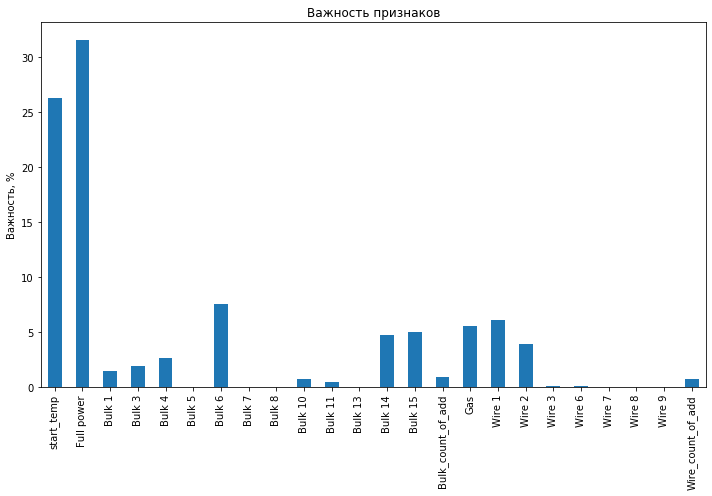

In [84]:
cat = pd.Series(catboost.get_feature_importance(),
                         df_2.drop(['end_temp'], axis=1).columns)
fig, ax = plt.subplots(figsize=(10,7))
cat.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()

На графике видно, что важный признаки это Полная мощность, начальная температура, в меньшей степени присыпка 6, присыпка 14, присыпка 15, продувка газом, проволка 1 и проволка 2 

# Вывод

- На первым этапе работы выполнили:
   - Импортировали необходимые библиотеки
   - Загрузили датасеты
   - Провели первичный осмотр каждого датасета
   - Определяли пропуски 
   - Проверили данные на аномальность
   - Заполнили пропуски
   - Изменили формат данных в некоторых столбцах
   - Убрали объекты, не имеющие достаточно признаков для изучения
   - Проверили признаки на мультиколлиниарность
   - Создали 2 датасета для моделирования 
- На этапе Агрегирования 
   - Масштабировали количественные признаки
   - Подготовили датасеты для обучения
   - Определили целевой признак
   - Поделили датасеты на выборки: Обучающаю и тестовую
   - Выбрали 4 модели для работы: Linear Regression, Random Forest, LGBMRegression, CatBoost
   - Обучили каждую модель и предсказали на тестовой выборке
   - Сравнили результаты по метрике MAE 
- На последнем этапе:
  - Определили лучшую модель и результат метрики ( CatBoost с параметрами 'depth': 3, 'learning_rate': 0.05, на данных df_2, MAE on test: 5.66)
  - Определили важность признаков для модели победителя